Libraries and Imports

In [20]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.utils.data as data
import torchmetrics
from ncps.torch import LTC
from ncps.wirings import AutoNCP
from plyer import notification
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

sys.path.append(os.path.abspath("funcs"))

from config_reading import read_and_validate_training_json
from latest_log import get_latest_csv
from timer_callback import TimingCallback

Opening configuration file

In [21]:
config = read_and_validate_training_json()

Setting the CUDA float32 precision.

In [22]:
torch.set_float32_matmul_precision(config["float_precision"])

Set the seed manually to ensure reproducibility

In [23]:
seed = config["seed"]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
pl.seed_everything(seed, workers=True)

Seed set to 1234


1234

Reading the dataset.

In [24]:
train_x = torch.load(os.path.join(config["save_path"], "tensor_train_x.pt"))
train_y = torch.load(os.path.join(config["save_path"], "tensor_train_y.pt"))
val_x = torch.load(os.path.join(config["save_path"], "tensor_val_x.pt"))
val_y = torch.load(os.path.join(config["save_path"], "tensor_val_y.pt"))
test_x = torch.load(os.path.join(config["save_path"], "tensor_test_x.pt"))
test_y = torch.load(os.path.join(config["save_path"], "tensor_test_y.pt"))

Defining loaders, models phases and model configuration

In [25]:
print(f"Train:{train_x.shape[0]}\nVal:{val_x.shape[0]}\nTest:{test_x.shape[0]}")

Train:6616
Val:736
Test:2947


In [26]:
train_batch, val_batch, test_batch = config["batch_sizes"]

In [27]:
train_dataloader = data.DataLoader(data.TensorDataset(train_x, train_y), batch_size=train_batch, shuffle=True, num_workers=16, persistent_workers=True)
val_dataloader = data.DataLoader(data.TensorDataset(val_x, val_y), batch_size=val_batch, num_workers=16, persistent_workers=True)
test_dataloader = data.DataLoader(data.TensorDataset(test_x, test_y), batch_size=test_batch, num_workers=16, persistent_workers=True)

In [28]:
class SequenceLearner(pl.LightningModule):
	def __init__(self, model, lr):
		super().__init__()
		self.model = model
		self.lr = lr
		self.loss_fn = nn.CrossEntropyLoss()
		self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=6)
		self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=6)
		self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=6)
		self.log_collection = []

	def training_step(self, batch, batch_idx):
		x, y = batch
		y_hat, _ = self.model.forward(x)
		loss = self.loss_fn(y_hat, y)
		y_pred = y_hat.argmax(dim=-1)
		self.log_collection.append({"loss": loss, "acc": self.train_acc(y_pred, y)})
		return {"loss": loss}

	def validation_step(self, batch, batch_idx):
		x, y = batch
		y_hat, _ = self.model.forward(x)
		loss = self.loss_fn(y_hat, y)
		y_pred = y_hat.argmax(dim=-1)
		self.log_collection.append({"loss": loss, "acc": self.val_acc(y_pred, y)})
		return {"loss": loss}
	
	def test_step(self, batch, batch_idx):
		x, y = batch
		y_hat, _ = self.model.forward(x)
		loss = self.loss_fn(y_hat, y)
		y_pred = y_hat.argmax(dim=-1)
		self.log("test_loss", loss)
		self.log("test_acc", self.test_acc(y_pred, y))
		return {"loss": loss}

	def on_validation_epoch_end(self):
		self.log("train_loss", self.log_collection[0]["loss"], on_step=False, on_epoch=True)
		self.log("train_acc", self.log_collection[0]["acc"], on_step=False, on_epoch=True)
		self.log("val_loss", self.log_collection[1]["loss"], on_step=False, on_epoch=True)
		self.log("val_acc", self.log_collection[1]["acc"], on_step=False, on_epoch=True)
		self.log_collection = []


	def configure_optimizers(self):
		return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [29]:
out_features = 6 # Output
in_features = 561 # Input

In [30]:
wiring = AutoNCP(config["num_neurons"], out_features)

In [31]:
ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=config["learning_rate"])

log_dir = f"logs"
logger = CSVLogger(log_dir, name=config["model_name"])

checkpoint_dir = f"{log_dir}/{config["model_name"]}/checkpoints"
last_checkpoint_path = f"{checkpoint_dir}/last.ckpt"
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="{epoch}-{val_loss:.2f}",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    save_last=True
)

trainer = pl.Trainer(
	logger=logger,
	max_epochs=201,
  check_val_every_n_epoch=1,
  callbacks=[TimingCallback(), checkpoint_callback],
	gradient_clip_val=1  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


Training

In [39]:
trainer.fit(learn, train_dataloader, val_dataloader)

c:\Users\Gusta\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\Gusta\Documents\liquid-neural-network\src\logs\ex001\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | LTC                | 201 K 
1 | loss_fn   | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
161 K     Trainable params
40.0 K    Non-trainable params
201 K     Total params
0.805     Total estimated model params size (MB)


c:\Users\Gusta\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=200` reached.


Testing and Ploting Results

In [33]:
trainer.test(learn, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9402782320976257     │
│         test_loss         │    0.19143876433372498    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19143876433372498, 'test_acc': 0.9402782320976257}]

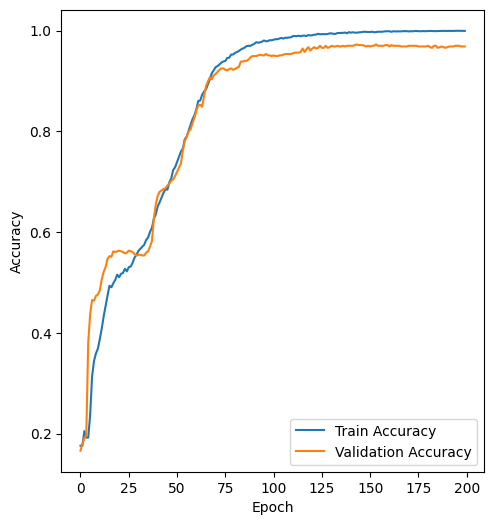

In [34]:
latest_csv = get_latest_csv(logger.log_dir)
metrics = pd.read_csv(latest_csv)

steps = metrics["epoch"]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, metrics["train_acc"], label='Train Accuracy')
plt.plot(steps, metrics["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

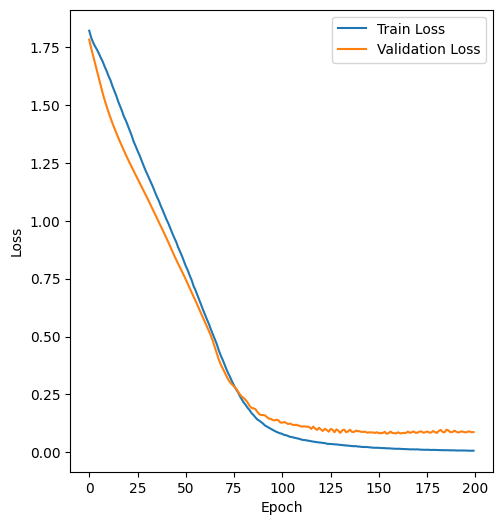

In [35]:
latest_csv = get_latest_csv(logger.log_dir)
metrics = pd.read_csv(latest_csv)

steps = metrics["epoch"]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, metrics["train_loss"], label='Train Loss')
plt.plot(steps, metrics["val_loss"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Saving the trained model

In [36]:
if not os.path.exists("models"):
	os.makedirs("models")

torch.save(ltc_model, f"models/{config["model_name"]}.pt")

Saving the configuration used

In [37]:
config_file_path = os.path.join(logger.log_dir, "config.json")
with open(config_file_path, 'w') as config_file:
	json.dump(config, config_file, indent=2)

Notification for end of training

In [38]:
notification.notify(
	title="Training ended",
	message=f"The training of the model {config["model_name"]} with {config["max_epochs"]} epochs has been completed.",
	timeout=10
)